## Score the Organizations Using the Name, Alternative Name, and Previous Name Fields

In [1]:
import pandas as pd
import numpy as np
import time
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')

t0=time.time()

df=pd.read_csv("../csvResults/cleanCityStatesPreAltNamesStdDataCityLatLongAddLatLongAgtLatLongDataLatLong_0_274491.csv")

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df.info(null_counts=True),df.head())

Total time is 0.031922 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       345276 non-null  int64  
 1   assignee_id              345276 non-null  object 
 2   location_id              345276 non-null  object 
 3   organization             345276 non-null  object 
 4   city                     340802 non-null  object 
 5   state                    344782 non-null  object 
 6   city_latitude            327486 non-null  float64
 7   city_longitude           327486 non-null  float64
 8   dateOfFirstPat           345276 non-null  object 
 9   name                     233691 non-null  object 
 10  jurisdiction_code        233691 non-null  object 
 11  incorporation_date       233691 non-null  object 
 12  alternative_names_clean  345276 non-null  object 
 13  previous_names_clean     345276

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,name,...,address_latitude,address_longitude,agent_city,agent_state,agent_latitude,agent_longitude,data_city,data_states,data_latitude,data_longitude
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,close in solutions,...,30.5229,-97.6776,NaN,NaN,NaN,NaN,round rock,tx,30.5229,-97.6776
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley payroll management and business solutions,...,NaN,NaN,NaN,NaN,NaN,NaN,alexandria,al,33.7740,-85.8855
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley business solutions,...,NaN,NaN,NaN,NaN,NaN,NaN,huntsville,al,34.7015,-86.5766
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,railias holdings,...,NaN,NaN,san diego,ca,32.8247,-117.152,san diego,ca,32.8247,-117.1520
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,fairdale orthodontic company,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
### score the organization names against the name, alternative_names_clean, and previous_names_clean features

t0=time.time()

df['organization']=df['organization'].str.lstrip()
df['organization']=df['organization'].str.rstrip()

df['name']=df['name'].str.lstrip()
df['name']=df['name'].str.rstrip()

df['alternative_names_clean']=df['alternative_names_clean'].str.lstrip()
df['alternative_names_clean']=df['alternative_names_clean'].str.rstrip()

df['previous_names_clean']=df['previous_names_clean'].str.lstrip()
df['previous_names_clean']=df['previous_names_clean'].str.rstrip()

a=len(df)
mat1=[]
mat2=[]

for i in range(a):

    ### try/except is used to bypass cells with an NaN. Removing this will force the user
    ### to deal with exception errors
    try:
        ### calculate the fuzzy score for further evaluation
        q=fuzz.ratio(df['organization'][i], df['name'][i])

        ### most simplest and most representative in the data; if the score is 100, it is
        ### a perfect match, otherwise, the remaining code will resolve score differences
        if q == 100:
            mat1.append(q)
            mat2.append(df['organization'][i])

        elif ( q != 100 ):

#             ### calculate the size of the data in each row for the alternative_names_clean
#             ### column and previous_names_clean column
            if pd.isnull(df['alternative_names_clean'][i]):
                r=0
            
            else:
                r=len(df['alternative_names_clean'][i])
            
            if pd.isnull(df['previous_names_clean'][i]):
                d=0
                
            else:
                d=len(df['previous_names_clean'][i])
                        
            ### the remaining parts of the code uses if statements to step through the many
            ### conditions that may be present in the data. As each condition is satisfied,
            ### the mat1 and mat2 lists are appended with the data; take note that q is the
            ### original score and s, v, e, and f are separate scores that are compared
            ### against q
            if r == 0 and d == 0:
                mat1.append(q)
                mat2.append(df['name'][i])
                                         
            ### calculate the score for the alternative_names_clean and previous_names_clean
            ### columns. Once calculated, they are compared against each other and q to
            ### determine the score that is highest. The 'best' score is appened to mat1 and
            ### the name of the organization is appended to mat2. The same scorer is utilized 
            ### as the above but the process.extractOne function retrieves the organization
            ### match with the highest score and saves it as a tuple
            elif r == 1 and d == 1:
                s=process.extractOne(df['organization'][i], df['alternative_names_clean'][i],scorer=fuzz.ratio)
                e=process.extractOne(df['organization'][i], df['previous_names_clean'][i],scorer=fuzz.ratio)
                
                if s[1] > e[1] and s[1] > q:
                    mat1.append(s[1])
                    mat2.append(s[0])
                
                elif e[1] > s[1] and e[1] > q:
                    mat1.append(e[1])
                    mat2.append(e[0])
                
                elif e[1] == q or s[1] == q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
                
                else:
                    mat1.append(q)
                    mat2.append(df['name'][i])
            
            ### this section is the same as above, except the code is looking at the
            ### alternative_names_clean column only
            elif r == 1:
                s=process.extractOne(df['organization'][i], df['alternative_names_clean'][i],scorer=fuzz.ratio)

                if s[1] > q:
                    mat1.append(s[1])
                    mat2.append(s[0])
                
                elif s[1] == q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
                    
                elif s[1] < q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
            
            ### this section is the same as above, except the code is looking at the
            ### previous_names_clean column only
            elif d == 1:
                e=process.extractOne(df['organization'][i], df['previous_names_clean'][i],scorer=fuzz.ratio)

                if e[1] > q:
                    mat1.append(e[1])
                    mat2.append(e[0])
                
                elif e[1] == q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
                    
                elif e[1] < q:
                    mat1.append(q)
                    mat2.append(df['name'][i])      
            
            ## the following two sections resolve r and d lengths greater than 1 (i.e.,
            ## records that have more than 1 company names in the alternative_names_clean 
            ## and previous_names_clean columns)
            elif r > 1:
                v=process.extractOne(df['organization'][i], df['alternative_names_clean'][i],scorer=fuzz.ratio)                

                if v[1] > q:
                    mat1.append(v[1])
                    mat2.append(v[0])
                    
                elif v[1] == q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
                    
                elif v[1] < q:
                    mat1.append(q)
                    mat2.append(df['name'][i])
            
            elif d > 1:
                f=process.extractOne(df['organization'][i], df['previous_names_clean'][i],scorer=fuzz.ratio)

                if f[1] > q:
                    mat1.append(f[1])
                    mat2.append(f[0])
                    
                elif f[1] == q:
                    mat1.append(q)
                    mat2.append(df['name'][i])                    
                    
                elif f[1] < q:
                    mat1.append(q)
                    mat2.append(df['name'][i])

    except:
        ### error handling that places an NaN for every cells that does not have a value
        ### in the mat1 and/or mat2 lists
        mat1.append(np.nan)
        mat2.append(np.nan)
        
t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

Total time is 0.298895 mins


In [3]:
### combines mat1 and mat2 into a single dataframe

t0=time.time()

finalList=[list(w) for w in zip(mat1, mat2)]
finalListDf=pd.DataFrame(finalList,columns=['scores','names'])

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(finalListDf.info(),finalListDf.head(n=25))

Total time is 0.009185 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   scores  233691 non-null  float64
 1   names   233691 non-null  object 
dtypes: float64(1), object(1)
memory usage: 5.3+ MB


None

,scores,names
0,100.0,close in solutions
1,68.0,valley payroll management and business solutions
2,100.0,valley business solutions
3,100.0,railias holdings
4,100.0,fairdale orthodontic company
5,100.0,compsci resources
6,100.0,maxmile technologies
7,100.0,kalyra pharmaceuticals
8,100.0,aprius
9,43.0,aprius medical service


In [4]:
### appends the original dataframe with the results from the scoring steps
### in the preceeding code blocks

t0=time.time()

df['nameScores'] = finalListDf['scores']
df['matchNames'] = finalListDf['names']

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df.info(),df.head())

Total time is 0.000195 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       345276 non-null  int64  
 1   assignee_id              345276 non-null  object 
 2   location_id              345276 non-null  object 
 3   organization             345276 non-null  object 
 4   city                     340802 non-null  object 
 5   state                    344782 non-null  object 
 6   city_latitude            327486 non-null  float64
 7   city_longitude           327486 non-null  float64
 8   dateOfFirstPat           345276 non-null  object 
 9   name                     233691 non-null  object 
 10  jurisdiction_code        233691 non-null  object 
 11  incorporation_date       233691 non-null  object 
 12  alternative_names_clean  345276 non-null  object 
 13  previous_names_clean     345276

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,name,...,agent_city,agent_state,agent_latitude,agent_longitude,data_city,data_states,data_latitude,data_longitude,nameScores,matchNames
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,close in solutions,...,NaN,NaN,NaN,NaN,round rock,tx,30.5229,-97.6776,100.0,close in solutions
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley payroll management and business solutions,...,NaN,NaN,NaN,NaN,alexandria,al,33.7740,-85.8855,68.0,valley payroll management and business solutions
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley business solutions,...,NaN,NaN,NaN,NaN,huntsville,al,34.7015,-86.5766,100.0,valley business solutions
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,railias holdings,...,san diego,ca,32.8247,-117.152,san diego,ca,32.8247,-117.1520,100.0,railias holdings
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,fairdale orthodontic company,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,fairdale orthodontic company


In [5]:
### rearrange the columns

t0=time.time()

df1=df

ten_col = df1.pop('nameScores')
ele_col = df1.pop('matchNames')

df1.insert(10, 'nameScores', ten_col)
df1.insert(11, 'matchNames', ele_col)

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df1.info(),df1.head())

Total time is 0.001368 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       345276 non-null  int64  
 1   assignee_id              345276 non-null  object 
 2   location_id              345276 non-null  object 
 3   organization             345276 non-null  object 
 4   city                     340802 non-null  object 
 5   state                    344782 non-null  object 
 6   city_latitude            327486 non-null  float64
 7   city_longitude           327486 non-null  float64
 8   dateOfFirstPat           345276 non-null  object 
 9   name                     233691 non-null  object 
 10  nameScores               233691 non-null  float64
 11  matchNames               233691 non-null  object 
 12  jurisdiction_code        233691 non-null  object 
 13  incorporation_date       233691

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,name,...,address_latitude,address_longitude,agent_city,agent_state,agent_latitude,agent_longitude,data_city,data_states,data_latitude,data_longitude
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,close in solutions,...,30.5229,-97.6776,NaN,NaN,NaN,NaN,round rock,tx,30.5229,-97.6776
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley payroll management and business solutions,...,NaN,NaN,NaN,NaN,NaN,NaN,alexandria,al,33.7740,-85.8855
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,valley business solutions,...,NaN,NaN,NaN,NaN,NaN,NaN,huntsville,al,34.7015,-86.5766
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,railias holdings,...,NaN,NaN,san diego,ca,32.8247,-117.152,san diego,ca,32.8247,-117.1520
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,fairdale orthodontic company,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
### removed columns that will not be used in the scoring steps

t0=time.time()

df1.drop(labels=['name','alternative_names_clean','previous_names_clean'],axis=1,inplace=True)

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df1.info(),df1.head())

Total time is 0.001149 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,address_latitude,address_longitude,agent_city,agent_state,agent_latitude,agent_longitude,data_city,data_states,data_latitude,data_longitude
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,30.5229,-97.6776,NaN,NaN,NaN,NaN,round rock,tx,30.5229,-97.6776
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,alexandria,al,33.7740,-85.8855
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,huntsville,al,34.7015,-86.5766
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,NaN,NaN,san diego,ca,32.8247,-117.152,san diego,ca,32.8247,-117.1520
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# df1.to_csv("../csvResults/patentsviewOCResultsScoredNamesCombined_0_274491.csv",index=False)

## Score the City and State Matches using the Fuzz Ratio Scorer

In [8]:
### this explanation applies to scoring the address_city/state, agent_city/state,
### and the data_city/state. The fields are cleaned of whitespace on the right and 
### left of the strings to enhance the matching steps. For loops are used to step 
### through all records line-by-line and compare the two cities or states. If a 
### blank record is present in either of the city fields, the list of scores is
### appended with a 'NaN' instead of a score. This allows the for loop to continue 
### without presenting with an error. When the loops are finished, the list of 
### scores are added to the end of the dataframe.

t0=time.time()

cityAddCity=[]
cityAgtCity=[]
cityDataCity=[]
df1['city']=df1['city'].str.lstrip()
df1['city']=df1['city'].str.rstrip()
df1['address_city']=df1['address_city'].str.lstrip()
df1['address_city']=df1['address_city'].str.rstrip()
df1['agent_city']=df1['agent_city'].str.lstrip()
df1['agent_city']=df1['agent_city'].str.rstrip()
df1['data_city']=df1['data_city'].str.lstrip()
df1['data_city']=df1['data_city'].str.rstrip()

for i in range(a):
    
    try:
        cityAddCity.append(fuzz.ratio(df1['city'][i], df1['address_city'][i]))
        
    except:
        cityAddCity.append(np.nan)
    
    try:
        cityAgtCity.append(fuzz.ratio(df1['city'][i], df1['agent_city'][i]))
        
    except:
        cityAgtCity.append(np.nan)
    
    try:
        cityDataCity.append(fuzz.ratio(df1['city'][i], df1['data_city'][i]))
        
    except:
        cityDataCity.append(np.nan)

### add the match scores to the dataframe

df1['addCityScore'] = cityAddCity
df1['agtCityScore'] = cityAgtCity
df1['dataCityScore'] = cityDataCity

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df1.info(),df1.head())

Total time is 0.269493 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,agent_state,agent_latitude,agent_longitude,data_city,data_states,data_latitude,data_longitude,addCityScore,agtCityScore,dataCityScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,NaN,NaN,NaN,round rock,tx,30.5229,-97.6776,25.0,NaN,25.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,NaN,NaN,NaN,alexandria,al,33.7740,-85.8855,NaN,NaN,20.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,NaN,NaN,NaN,huntsville,al,34.7015,-86.5766,NaN,NaN,100.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,ca,32.8247,-117.152,san diego,ca,32.8247,-117.1520,100.0,100.0,100.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
t0=time.time()

stateAddState=[]
stateAgtState=[]
stateDataState=[]

for i in range(a):
    
    try:
        stateAddState.append(fuzz.ratio(df1['state'][i], df1['address_state'][i]))
        
    except:
        stateAddState.append(np.nan)
        
    try:
        stateAgtState.append(fuzz.ratio(df1['state'][i], df1['agent_state'][i]))
        
    except:
        stateAgtState.append(np.nan)
    
    try:
        stateDataState.append(fuzz.ratio(df1['state'][i], df1['data_states'][i]))
        
    except:
        stateDataState.append(np.nan)
        
df1['stateAddScore'] = stateAddState
df1['stateAgtScore'] = stateAgtState
df1['stateDataScore'] = stateDataState

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df1.info(),df1.head())

Total time is 0.242437 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,data_city,data_states,data_latitude,data_longitude,addCityScore,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,round rock,tx,30.5229,-97.6776,25.0,NaN,25.0,100.0,NaN,100.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,alexandria,al,33.7740,-85.8855,NaN,NaN,20.0,NaN,NaN,100.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,huntsville,al,34.7015,-86.5766,NaN,NaN,100.0,NaN,NaN,100.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,san diego,ca,32.8247,-117.1520,100.0,100.0,100.0,NaN,100.0,100.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# df1.to_csv("../csvResults/patentsviewOCResultsScoredNamesCitiesStatesCombined_0_274491.csv",index=False)

## Calculate Distance between Cities if City Names are Different

In [1]:
import pandas as pd
import numpy as np
import time
from geopy import distance
from fuzzywuzzy import fuzz
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

t0=time.time()

df2=pd.read_csv("../csvResults/patentsviewOCResultsScoredNamesCitiesStatesCombined_0_274491.csv")

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df2.info(null_counts=True),df2.head())

Total time is 0.024763 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,data_city,data_states,data_latitude,data_longitude,addCityScore,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,round rock,tx,30.5229,-97.6776,25.0,NaN,25.0,100.0,NaN,100.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,alexandria,al,33.7740,-85.8855,NaN,NaN,20.0,NaN,NaN,100.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,huntsville,al,34.7015,-86.5766,NaN,NaN,100.0,NaN,NaN,100.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,san diego,ca,32.8247,-117.1520,100.0,100.0,100.0,NaN,100.0,100.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
### the distance between cities are calculated by utilizing the city_lat/city_long
### and the add_lat/add_long, agt_lat/agt_long, and data_lat/data_long features.

t0=time.time()

cityAddrCor=[]
cityAgtCor=[]
cityDataCor=[]

for p in range(len(df2)):
    
    try:
        cityCor = (df2.iloc[p,6], df2.iloc[p,7])
        cityAddressCor = (df2.iloc[p,15], df2.iloc[p,16])

        cityAddrCor.append(distance.distance(cityCor, cityAddressCor).miles)
    
    except:
        cityAddrCor.append(np.nan)
        
for p in range(len(df2)):
    
    try:
        cityCor = (df2.iloc[p,6], df2.iloc[p,7])
        cityAgentCor = (df2.iloc[p,19], df2.iloc[p,20])

        cityAgtCor.append(distance.distance(cityCor, cityAgentCor).miles)
    
    except:
        cityAgtCor.append(np.nan)

for p in range(len(df2)):
    
    try:
        cityCor = (df2.iloc[p,6], df2.iloc[p,7])
        cityDatCor = (df2.iloc[p,23], df2.iloc[p,24])

        cityDataCor.append(distance.distance(cityCor, cityDatCor).miles)
    
    except:
        cityDataCor.append(np.nan)
        
cityAddrCor1=[round(num, 1) for num in cityAddrCor]
cityAgtCor1=[round(num1, 1) for num1 in cityAgtCor]
cityDataCor1=[round(num1, 1) for num1 in cityDataCor]

df2['cityToAddrDistance'] = cityAddrCor1
df2['cityToAgtDistance'] = cityAgtCor1
df2['cityToDataDistance'] = cityDataCor1

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df2.info(),df2.head())

Total time is 2.990371 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,data_longitude,addCityScore,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,-97.6776,25.0,NaN,25.0,100.0,NaN,100.0,15.0,NaN,15.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,-85.8855,NaN,NaN,20.0,NaN,NaN,100.0,NaN,NaN,75.2
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,-86.5766,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN,0.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,-117.1520,100.0,100.0,100.0,NaN,100.0,100.0,NaN,0.0,0.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# df2.to_csv("../csvResults/patentsviewOCResultsScoredNamesCitiesStatesCordinatesCombined_0_274491.csv",index=False)

## Score State Jurisdiction Against State Listed in Patentsview

In [4]:
### the jurisdiction code will be scored against the state and appended to the
### final dataset before scoring

df3=df2

d=len(df3)
jurisScore=[]

for t in range(d):
    try:
        jurisScore.append(fuzz.ratio(df3['state'][t],df3['jurisdiction_code'][t].replace('us_','')))      

    except:
        jurisScore.append(np.nan)
        
df3['jurisdictionScore'] = jurisScore

display(df3.info(),df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233691 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  address_latitude    144069 non-nul

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,addCityScore,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,10/18/2011,100.0,...,25.0,NaN,25.0,100.0,NaN,100.0,15.0,NaN,15.0,100.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,68.0,...,NaN,NaN,20.0,NaN,NaN,100.0,NaN,NaN,75.2,100.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,6/30/2020,100.0,...,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN,0.0,100.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,12/15/2020,100.0,...,100.0,100.0,100.0,NaN,100.0,100.0,NaN,0.0,0.0,100.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,9/22/1987,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [5]:
### the time between the first patent granted and incorporation date is calculated
### and appended to the final dataset before scoring

df3['dateOfFirstPat'] = pd.to_datetime(df3['dateOfFirstPat'])
df3['incorporation_date'] = pd.to_datetime(df3['incorporation_date'],errors='coerce')

df3['dateDiff']=abs(df3['incorporation_date'] - df3['dateOfFirstPat'])/ timedelta(days=365)
df3['dateDiff']=[round(num, 2) for num in df3['dateDiff']]

display(df3.info(),df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ID                  345276 non-null  int64         
 1   assignee_id         345276 non-null  object        
 2   location_id         345276 non-null  object        
 3   organization        345276 non-null  object        
 4   city                340802 non-null  object        
 5   state               344782 non-null  object        
 6   city_latitude       327486 non-null  float64       
 7   city_longitude      327486 non-null  float64       
 8   dateOfFirstPat      345276 non-null  datetime64[ns]
 9   nameScores          233691 non-null  float64       
 10  matchNames          233691 non-null  object        
 11  jurisdiction_code   233691 non-null  object        
 12  incorporation_date  233649 non-null  datetime64[ns]
 13  address_city        155625 no

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,NaN,25.0,100.0,NaN,100.0,15.0,NaN,15.0,100.0,1.56
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,68.0,...,NaN,20.0,NaN,NaN,100.0,NaN,NaN,75.2,100.0,12.08
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,NaN,100.0,NaN,NaN,100.0,NaN,NaN,0.0,100.0,12.67
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,100.0,100.0,NaN,100.0,100.0,NaN,0.0,0.0,100.0,0.73
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,19.94


In [6]:
# df3.to_csv("../csvResults/patentsviewOCResultsScoredNamesCitiesStatesCordinatesJurisdictionDateDiffCombined_0_274491.csv",index=False)

## Scoring Algorithm

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

t0=time.time()

df4=pd.read_csv("../csvResults/patentsviewOCResultsScoredNamesCitiesStatesCordinatesJurisdictionDateDiffCombined_0_274491.csv")

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df4.info(null_counts=True),df4.head())

Total time is 0.033166 mins
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233649 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,agtCityScore,dataCityScore,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,NaN,25.0,100.0,NaN,100.0,15.0,NaN,15.0,100.0,1.56
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,68.0,...,NaN,20.0,NaN,NaN,100.0,NaN,NaN,75.2,100.0,12.08
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,NaN,100.0,NaN,NaN,100.0,NaN,NaN,0.0,100.0,12.67
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,100.0,100.0,NaN,100.0,100.0,NaN,0.0,0.0,100.0,0.73
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,19.94


In [3]:
### calculates the record completeness. In other words, if the record contains more
### information, it will score a higher number than another record that contains a
### minimal amount of data. The higher scores are related to a greater confidence
### the record is 'complete'.

a=df4.iloc[:,:].count(axis=1)
df4['rdCompleteness']=round(a/10)

display(df4.head())

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,dataCityScore,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff,rdCompleteness
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,25.0,100.0,NaN,100.0,15.0,NaN,15.0,100.0,1.56,3.0
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,68.0,...,20.0,NaN,NaN,100.0,NaN,NaN,75.2,100.0,12.08,2.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,100.0,NaN,NaN,100.0,NaN,NaN,0.0,100.0,12.67,2.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,100.0,NaN,100.0,100.0,NaN,0.0,0.0,100.0,0.73,3.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,19.94,2.0


In [4]:
totalScore=[]
d=len(df4)
x=''
a=''

### score the fuzzy match percentages

for s in range(d):
    ### scores all records with a fuzzy match score with a 100%; account for organization
    ### name lengths (i.e., shorter names are scored lower than longer names)
    
    a=df4['rdCompleteness'][s]
    
    if df4['nameScores'][s] == 100:

        if len(df4['organization'][s]) < 5:
            x=0
        
        elif 5 <= len(df4['organization'][s]) < 10:
            x=2
            
        elif 10 <= len(df4['organization'][s]) < 15:
            x=4
            
        elif len(df4['organization'][s]) >= 15:
            x=5
    
    ### visual inspection of the data indicates a discrete group between 95% and 100%,
    ### resulting in the next set. Name lengths are again accounted for and shorter
    ### names/scores are downweighted even more
    
    elif 95 <= df4['nameScores'][s] < 100:
        
        if len(df4['organization'][s]) < 5:
            x=0
        
        elif 5 <= len(df4['organization'][s]) < 10:
            x=1
            
        elif 10 <= len(df4['organization'][s]) < 15:
            x=2
            
        elif len(df4['organization'][s]) >= 15:
            x=3

    ### many of the fuzzy matches in this range are wrong, but there are a couple correct
    ### that should not be discounted. While the weights are not as high as the previous
    ### sections, correct matches will be given better scores than the next section
    
    elif 90 <= df4['nameScores'][s] < 95:
        
        if len(df4['organization'][s]) < 5:
            x=-1
        
        elif 5 <= len(df4['organization'][s]) < 10:
            x=1
            
        elif 10 <= len(df4['organization'][s]) < 15:
            x=2
            
        elif len(df4['organization'][s]) >= 15:
            x=3

    ### very few are correct, but there are some misspellings that were not collected during
    ### the cleaning phase. Many of the records will be weighted down, but those that are
    ### longer in length will be given higher scores than names that are shorter
    
    elif 87 <= df4['nameScores'][s] < 90:
        
        if len(df4['organization'][s]) < 5:
            x=-1
        
        if 5 <= len(df4['organization'][s]) < 10:
            x=0.5
            
        elif 10 <= len(df4['organization'][s]) < 15:
            x=1
            
        elif len(df4['organization'][s]) >= 15:
            x=1.5
        
    elif df4['nameScores'][s] < 87:
        x=-7
        
    elif np.isnan(df4['nameScores'][s]):
        x=-10

    ### scoring the different features that contain state information for each
    ### organization. The jurisdictionScore feature was created by extracting
    ### the state from the jurisdiction_code field. The jurisdiction_code
    ### feature is the primary metric used to match patentsview and OC records
    ### and therefore, given a larger weight. The stateAddScore is given the
    ### second highest weight because it is the primary address that is listed
    ### in an OC record. stateAgtScore is given the least amount of weight
    ### because the agent may not always be located at the registered address 
    ### for the organization.
    
    #####jurisdiction scoring was removed
    
    if df4['stateAddScore'][s] == 100 or df4['stateAgtScore'][s] == 100 or df4['stateDataScore'][s] == 100:
        x=x+2
        
    else:
        x=x+0
      
    ### the address_city feature is weighted more than the agent_city column for similar
    ### reasons stated in the states section above. Cities less than 4 characters long
    ### are penalized and gradually score better as the character length increase. Moreover,
    ### the score from fuzzy matching is used to create groups as shown below. Fuzzy
    ### scores below 90% are weighted negatively
    
#     if df4['addCityScore'][s] == 100:
        
#         if len(df4['address_city'][s]) < 4:
#             x=x-3
        
#         elif 4 <= len(df4['address_city'][s]) < 10:
#             x=x+1
            
#         elif 10 <= len(df4['address_city'][s]) < 15:
#             x=x+3
            
#         elif len(df4['address_city'][s]) >= 15:
#             x=x+5
        
#         elif len(df4['address_city'][s]) == 0:
#             x=x+0
            
#         elif np.isnan(df4['address_city'][s]):
#             x=x+0
    
#     elif 90 <= df4['addCityScore'][s] < 100:

#         if len(df4['address_city'][s]) < 4:
#             x=x-5
        
#         elif 4 <= len(df4['address_city'][s]) < 7:
#             x=x+1
            
#         elif 7 <= len(df4['address_city'][s]) < 10:
#             x=x+3
            
#         elif len(df4['address_city'][s]) >= 10:
#             x=x+5
        
#         elif len(df4['address_city'][s]) == 0:
#             x=x+0
            
#         elif np.isnan(df4['address_city'][s]):
#             x=x+0
    
#     elif df4['addCityScore'][s] < 90:
        
#         x=x-6
    
    
#     if df4['agtCityScore'][s] == 100:

#         if len(df4['agent_city'][s]) < 4:
#             x=x-3

#         elif 4 <= len(df4['agent_city'][s]) < 7:
#             x=x+1

#         elif 7 <= len(df4['agent_city'][s]) < 10:
#             x=x+3

#         elif len(df4['agent_city'][s]) >= 10:
#             x=x+5

#         elif len(df4['agent_city'][s]) == 0:
#             x=x+0

#         elif np.isnan(df4['address_city'][s]):
#             x=x+0
    
#     elif 90 <= df4['agtCityScore'][s] < 100:

#         if len(df4['agent_city'][s]) < 4:
#             x=x-5

#         elif 4 <= len(df4['agent_city'][s]) < 7:
#             x=x+1

#         elif 7 <= len(df4['agent_city'][s]) < 10:
#             x=x+3

#         elif len(df4['agent_city'][s]) >= 10:
#             x=x+5

#         elif len(df4['agent_city'][s]) == 0:
#             x=x+0

#         elif np.isnan(df4['address_city'][s]):
#             x=x+0
            
#     elif df4['agtCityScore'][s] < 90:
        
#         x=x-6

            
#     if df4['dataCityScore'][s] == 100:

#         if len(df4['data_city'][s]) < 4:
#             x=x-3

#         elif 4 <= len(df4['data_city'][s]) < 7:
#             x=x+1

#         elif 7 <= len(df4['data_city'][s]) < 10:
#             x=x+3

#         elif len(df4['data_city'][s]) >= 10:
#             x=x+5

#         elif len(df4['data_city'][s]) == 0:
#             x=x+0

#         elif np.isnan(df4['data_city'][s]):
#             x=x+0
     
#     elif 90 <= df4['dataCityScore'][s] < 100:

#         if len(df4['data_city'][s]) < 4:
#             x=x-5

#         elif 4 <= len(df4['data_city'][s]) < 7:
#             x=x+1

#         elif 7 <= len(df4['data_city'][s]) < 10:
#             x=x+3

#         elif len(df4['data_city'][s]) >= 10:
#             x=x+5

#         elif len(df4['data_city'][s]) == 0:
#             x=x+0

#         elif np.isnan(df4['data_city'][s]):
#             x=x+0
            
#     elif df4['dataCityScore'][s] < 90:
        
#         x=x-6
   

    if df4['cityToAddrDistance'][s] == 0:
        x=x+4
    
    elif 0 < df4['cityToAddrDistance'][s] < 10:
        x=x+3      
       
    elif 10 <= df4['cityToAddrDistance'][s] < 50:
        x=x+2
    
    elif 50 <= df4['cityToAddrDistance'][s] < 100:
        x=x+1
    
    elif 100 <= df4['cityToAddrDistance'][s] < 200:
        x=x+0.50
    
    elif df4['cityToAddrDistance'][s] >= 200:
        x=x-2
    
        
    if df4['cityToAgtDistance'][s] == 0:
        x=x+4
    
    elif 0 < df4['cityToAgtDistance'][s] < 10:
        x=x+3
        
    elif 10 <= df4['cityToAgtDistance'][s] < 50:
        x=x+2
    
    elif 50 <= df4['cityToAgtDistance'][s] < 100:
        x=x+1
    
    elif 100 <= df4['cityToAgtDistance'][s] < 200:
        x=x+0.50

    
    elif df4['cityToAgtDistance'][s] >= 200:
        x=x-2
        
        
    if df4['cityToDataDistance'][s] == 0:
        x=x+4
    
    elif 0 < df4['cityToDataDistance'][s] < 10:
        x=x+3
        
    elif 10 <= df4['cityToDataDistance'][s] < 50:
        x=x+2
    
    elif 50 <= df4['cityToDataDistance'][s] < 100:
        x=x+1
    
    elif 100 <= df4['cityToDataDistance'][s] < 200:
        x=x+0.50
    
    elif df4['cityToDataDistance'][s] >= 200:
        x=x-2
        
    
    ### try this new algorithm
    
    if df4['addCityScore'][s] == 100 or df4['agtCityScore'][s] == 100 or df4['dataCityScore'][s] == 100:
        
        if df4['addCityScore'][s] == 100:
            
            if len(df4['address_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['address_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['address_city'][s]) < 15:
                x=x+3

            elif len(df4['address_city'][s]) >= 15:
                x=x+5

            elif len(df4['address_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['address_city'][s]):
                x=x+0
                
        
        elif df4['agtCityScore'][s] == 100:
            
            if len(df4['agent_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['agent_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['agent_city'][s]) < 15:
                x=x+3

            elif len(df4['agent_city'][s]) >= 15:
                x=x+5

            elif len(df4['agent_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['agent_city'][s]):
                x=x+0
                
        
        elif df4['dataCityScore'][s] == 100:
            
            if len(df4['data_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['data_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['data_city'][s]) < 15:
                x=x+3

            elif len(df4['data_city'][s]) >= 15:
                x=x+5

            elif len(df4['data_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['data_city'][s]):
                x=x+0


    if 90 <= df4['addCityScore'][s] < 100 or 90 <= df4['agtCityScore'][s] < 100 or 90 <= df4['dataCityScore'][s] < 100:
        
        if 90 <= df4['addCityScore'][s] < 100:
            
            if len(df4['address_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['address_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['address_city'][s]) < 15:
                x=x+3

            elif len(df4['address_city'][s]) >= 15:
                x=x+5

            elif len(df4['address_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['address_city'][s]):
                x=x+0
                
        
        elif 90 <= df4['agtCityScore'][s] == 100:
            
            if len(df4['agent_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['agent_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['agent_city'][s]) < 15:
                x=x+3

            elif len(df4['agent_city'][s]) >= 15:
                x=x+5

            elif len(df4['agent_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['agent_city'][s]):
                x=x+0
                
        
        elif 90 <= df4['dataCityScore'][s] == 100:
            
            if len(df4['data_city'][s]) < 5:
                x=x+0

            elif 5 <= len(df4['data_city'][s]) < 10:
                x=x+1

            elif 10 <= len(df4['data_city'][s]) < 15:
                x=x+3

            elif len(df4['data_city'][s]) >= 15:
                x=x+5

            elif len(df4['data_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['data_city'][s]):
                x=x+0
                
                
    if df4['addCityScore'][s] < 90 or df4['agtCityScore'][s] < 90 or df4['dataCityScore'][s] < 90:
        
        if df4['addCityScore'][s] < 90:
            
            if len(df4['address_city'][s]) > 0:
                x=x+0

            elif len(df4['address_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['address_city'][s]):
                x=x+0
                
        
        elif df4['agtCityScore'][s] < 90:
            
            if len(df4['agent_city'][s]) > 0:
                x=x+0

            elif len(df4['agent_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['agent_city'][s]):
                x=x+0
                
        
        elif df4['dataCityScore'][s] < 90:
            
            if len(df4['data_city'][s]) > 0:
                x=x+0

            elif len(df4['data_city'][s]) == 0:
                x=x+0

            elif np.isnan(df4['data_city'][s]):
                x=x+0
    
    
    try:
        if df4['dateDiff'][s] <= 3:
            x=x+3

        elif 3 < df4['dateDiff'][s] <= 5:
            x=x+1
        
        elif 5 < df4['dateDiff'][s] <= 10:
            x=x+0.5
            
        elif 10 < df4['dateDiff'][s] <= 15:
            x=x+0.25
            
        elif df4['dateDiff'][s] > 15:
            x=x+0

    except:
        print('cannot compare dates')
    
    totalScore.append(x+a)
    a=''

In [5]:
df4['totalScore'] = totalScore

display(df4.info(),df4.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345276 entries, 0 to 345275
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  345276 non-null  int64  
 1   assignee_id         345276 non-null  object 
 2   location_id         345276 non-null  object 
 3   organization        345276 non-null  object 
 4   city                340802 non-null  object 
 5   state               344782 non-null  object 
 6   city_latitude       327486 non-null  float64
 7   city_longitude      327486 non-null  float64
 8   dateOfFirstPat      345276 non-null  object 
 9   nameScores          233691 non-null  float64
 10  matchNames          233691 non-null  object 
 11  jurisdiction_code   233691 non-null  object 
 12  incorporation_date  233649 non-null  object 
 13  address_city        155625 non-null  object 
 14  address_state       150796 non-null  object 
 15  address_latitude    144069 non-nul

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,stateAddScore,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff,rdCompleteness,totalScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,100.0,NaN,100.0,15.0,NaN,15.0,100.0,1.56,3.0,17.00
1,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,68.0,...,NaN,NaN,100.0,NaN,NaN,75.2,100.0,12.08,2.0,-1.75
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,NaN,NaN,100.0,NaN,NaN,0.0,100.0,12.67,2.0,16.25
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,NaN,100.0,100.0,NaN,0.0,0.0,100.0,0.73,3.0,22.00
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,19.94,2.0,7.00


In [5]:
### this is blank because I no longer want to drop empty records because we need
### these for later calculations

# df4.dropna(subset=['nameScores'],inplace=True)

# display(df4.info(),df4.head())

In [7]:
# df4.to_csv("../csvResults/patentsviewOCResultsScored_0_274491_NotFiltered.csv",index=False)

## Filter Data According to Manually Identified Thresholds

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

t0=time.time()

df4=pd.read_csv("../csvResults/patentsviewOCResultsScored_0_274491_NotFiltered.csv")

df5=df4.loc[(df4['totalScore']>=0) & (df4['nameScores']>50)]

df5['confidenceScore']=((10-1)*((df5['totalScore']-min(df5['totalScore']))/(max(df5['totalScore'])-min(df5['totalScore']))))+1

df5['confidenceScore']=[round(num1, 2) for num1 in df5['confidenceScore']]

df5.drop_duplicates(inplace=True)

t1=time.time()
total=t1-t0
print("Total time is %4f" % (total/60), "mins")

display(df5.info(),df5.head())

Total time is 0.042914 mins
<class 'pandas.core.frame.DataFrame'>
Int64Index: 152563 entries, 0 to 345244
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  152563 non-null  int64  
 1   assignee_id         152563 non-null  object 
 2   location_id         152563 non-null  object 
 3   organization        152563 non-null  object 
 4   city                151360 non-null  object 
 5   state               152563 non-null  object 
 6   city_latitude       146803 non-null  float64
 7   city_longitude      146803 non-null  float64
 8   dateOfFirstPat      152563 non-null  object 
 9   nameScores          152563 non-null  float64
 10  matchNames          152563 non-null  object 
 11  jurisdiction_code   152563 non-null  object 
 12  incorporation_date  152547 non-null  object 
 13  address_city        107043 non-null  object 
 14  address_state       103242 non-null  object 
 15  addres

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff,rdCompleteness,totalScore,confidenceScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,NaN,100.0,15.0,NaN,15.0,100.0,1.56,3.0,17.00,5.94
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,NaN,100.0,NaN,NaN,0.0,100.0,12.67,2.0,16.25,5.72
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,100.0,100.0,NaN,0.0,0.0,100.0,0.73,3.0,22.00,7.39
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,100.0,19.94,2.0,7.00,3.03
5,7,fff83fa2-1d91-479a-93c7-a5835815c2f9,70867e08-cb8e-11eb-9615-121df0c29c1e,compsci resources,alexandria,va,38.8148,-77.0902,2012-07-24,100.0,...,100.0,NaN,0.0,0.0,NaN,100.0,14.87,3.0,21.25,7.17


In [2]:
df6=df5.sort_values(by=['nameScores'],ascending=False)
# df7=df6.sort_values(by=['ID'],ascending=True)
df7=df6.drop_duplicates(subset=['ID'],keep='first')
# df7=df6.drop_duplicates(subset=['assignee_id','organization'],keep='first')

# df8=df7.sort_values(by=['nameScores'],ascending=False)
# df9=df8.drop_duplicates(subset=['ID'],keep='first')

display(df7.info(),df7.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127620 entries, 0 to 161145
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  127620 non-null  int64  
 1   assignee_id         127620 non-null  object 
 2   location_id         127620 non-null  object 
 3   organization        127620 non-null  object 
 4   city                126639 non-null  object 
 5   state               127620 non-null  object 
 6   city_latitude       122955 non-null  float64
 7   city_longitude      122955 non-null  float64
 8   dateOfFirstPat      127620 non-null  object 
 9   nameScores          127620 non-null  float64
 10  matchNames          127620 non-null  object 
 11  jurisdiction_code   127620 non-null  object 
 12  incorporation_date  127606 non-null  object 
 13  address_city        88189 non-null   object 
 14  address_state       84847 non-null   object 
 15  address_latitude    81280 non-null

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff,rdCompleteness,totalScore,confidenceScore
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,NaN,100.0,15.0,NaN,15.0,100.0,1.56,3.0,17.0,5.94
207567,175540,74a03258-f66d-4a2b-af97-9632f3de9891,3cc56218-cb8e-11eb-9615-121df0c29c1e,visuron technologies,bay city,mi,43.5945,-83.8889,2004-09-28,100.0,...,NaN,NaN,80.6,NaN,NaN,100.0,17.41,2.0,10.0,3.90
207610,175573,7493990d-781a-4146-8e7c-a60ab60eb6a1,e295c332-cb8e-11eb-9615-121df0c29c1e,strong enterprises,orlando,fl,28.4810,-81.4496,2011-04-12,100.0,...,NaN,100.0,NaN,NaN,0.0,100.0,6.64,2.0,14.5,5.21
207602,175572,7494799f-0db2-44a4-a2f4-f832b33e7084,c59878f7-cb8f-11eb-9615-121df0c29c1e,golden valley microwave foods,eden prairie,mn,44.8454,-93.4597,1987-02-10,100.0,...,NaN,50.0,NaN,NaN,277.5,100.0,8.45,3.0,8.5,3.47
207601,175571,7494799f-0db2-44a4-a2f4-f832b33e7084,d9bae762-cb8f-11eb-9615-121df0c29c1e,golden valley microwave foods,edina,mn,44.8950,-93.3600,1987-02-10,100.0,...,NaN,50.0,NaN,NaN,282.9,100.0,8.45,3.0,8.5,3.47


In [3]:
col         = 'confidenceScore'
conditions  = [ (df7[col] >= 1) & (df7[col] < 2), (df7[col] >= 2) & (df7[col] < 3), (df7[col] >= 3) & (df7[col] < 4),
                (df7[col] >= 4) & (df7[col] < 5), (df7[col] >= 5) & (df7[col] < 6), (df7[col] >= 6) & (df7[col] < 7), 
                (df7[col] >= 7) & (df7[col] < 8), (df7[col] >= 8) & (df7[col] < 9), (df7[col] >= 9) & (df7[col] < 10),
                (df7[col] == 10) ]
choices     = [ 1,2,3,4,5,6,7,8,9,10 ]
    
df7["score"] = np.select(conditions, choices, default=np.nan)
df7.drop(columns=['confidenceScore'],inplace=True)
df8=df7.sort_values(by=['ID'])

display(df8.info(),df8.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127620 entries, 0 to 345244
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  127620 non-null  int64  
 1   assignee_id         127620 non-null  object 
 2   location_id         127620 non-null  object 
 3   organization        127620 non-null  object 
 4   city                126639 non-null  object 
 5   state               127620 non-null  object 
 6   city_latitude       122955 non-null  float64
 7   city_longitude      122955 non-null  float64
 8   dateOfFirstPat      127620 non-null  object 
 9   nameScores          127620 non-null  float64
 10  matchNames          127620 non-null  object 
 11  jurisdiction_code   127620 non-null  object 
 12  incorporation_date  127606 non-null  object 
 13  address_city        88189 non-null   object 
 14  address_state       84847 non-null   object 
 15  address_latitude    81280 non-null

None

,ID,assignee_id,location_id,organization,city,state,city_latitude,city_longitude,dateOfFirstPat,nameScores,...,stateAgtScore,stateDataScore,cityToAddrDistance,cityToAgtDistance,cityToDataDistance,jurisdictionScore,dateDiff,rdCompleteness,totalScore,score
0,0,fffe9f1f-cb1c-49ab-b00f-6416e3e3a909,fd8b2b76-cb90-11eb-9615-121df0c29c1e,close in solutions,austin,tx,30.3076,-97.7126,2011-10-18,100.0,...,NaN,100.0,15.0,NaN,15.0,100.0,1.56,3.0,17.00,5.0
2,3,fffe36bb-6dea-4a8b-8bf5-071cf893ceba,fe1cb1c3-cb8f-11eb-9615-121df0c29c1e,valley business solutions,huntsville,al,34.7015,-86.5766,2020-06-30,100.0,...,NaN,100.0,NaN,NaN,0.0,100.0,12.67,2.0,16.25,5.0
3,4,fffd9c21-3bb1-4471-b316-d172921e3f83,ec16f9be-cb90-11eb-9615-121df0c29c1e,railias holdings,san diego,ca,32.8247,-117.1520,2020-12-15,100.0,...,100.0,100.0,NaN,0.0,0.0,100.0,0.73,3.0,22.00,7.0
4,6,fffa8520-f0c2-431f-a64a-e16f3af0a896,fc25b086-cb8f-11eb-9615-121df0c29c1e,fairdale orthodontic company,cincinnati,oh,39.1366,-84.5135,1987-09-22,100.0,...,NaN,NaN,NaN,NaN,NaN,100.0,19.94,2.0,7.00,3.0
5,7,fff83fa2-1d91-479a-93c7-a5835815c2f9,70867e08-cb8e-11eb-9615-121df0c29c1e,compsci resources,alexandria,va,38.8148,-77.0902,2012-07-24,100.0,...,100.0,NaN,0.0,0.0,NaN,100.0,14.87,3.0,21.25,7.0


In [4]:
# df8.to_csv("../csvResults/screenScoredRecords_0_274491.csv",index=False)

In [10]:
# df8.sample(n=100,weights='score', random_state=42,)

df8.groupby("score").sample(n=20, random_state=42).to_csv("../csvResults/screenRandomSample_0_274491.csv",index=False)

In [10]:
import seaborn as sns

df5_100=df5.loc[df5['nameScores']==100]

<AxesSubplot:xlabel='totalScore', ylabel='Count'>

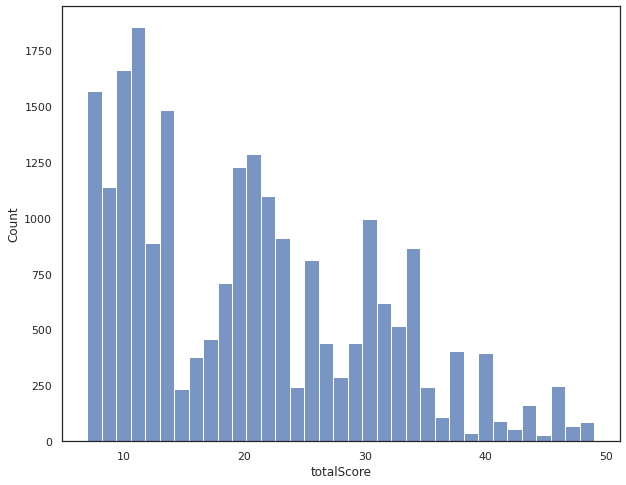

In [12]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.set_style("white")

sns.histplot(data=df5_100, x="totalScore")

<AxesSubplot:xlabel='totalScore', ylabel='Count'>

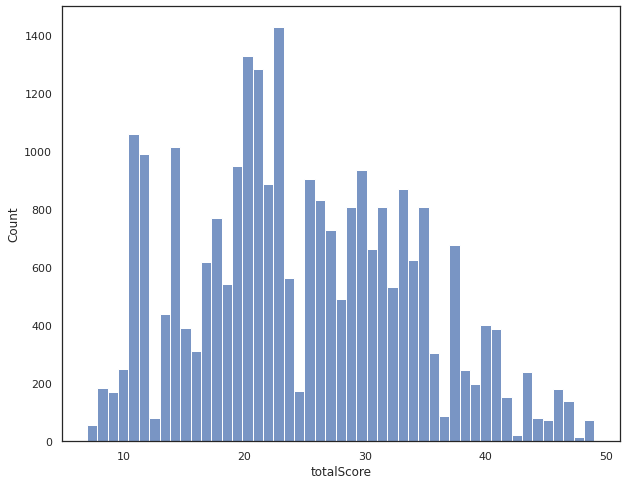

In [18]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.set_style("white")

sns.histplot(data=df5_100, x="totalScore")